# Project 1: Pose Graph Optimization (scratch + g2o)

TEAM-ID: 13 \
TEAM-NAME:   Gimme10  \
YOUR-ID:      2018102026\
YOUR-NAME:    Sampath Kumar

(Although you work in groups, both the students have to submit to Moodle, hence there's name field above)

### Submission
Zip a folder of the following:
1. Files that you were provided with: `Project-1.ipynb`, the folders `misc` and `dataset`. Rest of the files asked in the questions below must be generated when i run the code. If generation of any file is computationally intensive, add `filename_backup.extension` where `filename.extension` is the expected name of file when i run the code. (For example, next point.)
2. Add `opt_backup.g2o` (described below) in outermost directory. Here, `opt.g2o` is the expected name of the file when I run the code.
3. For images of any results (like plots), save it in `./misc` folder.

On Moodle, all you have to submit is the jupyter notebook. But make sure to call the necessary functions explicitly (as specified in the notebook). The name of the zipped file being submitted to Moodle Assignment portal MUST BE `ID_Teamname_Firstname`. More details [here](https://www.notion.so/saishubodh/Course-Information-4c9e487b118547b2ba91d24e0dcaf04e#f2707a04f2a0446bac77763b47ba4bac).

On GitHub classrooms, the latest commit before the deadline will be considered as the submission. 

The deadline is Oct 16, 23:55 IST. Please get started ASAP, there is no way you can finish this project during the last few days before the deadline.

### General instructions

This ipython notebook (`.ipynb`) on GitHub is self-sufficient and has all the information you need to get started with the assignment, you don't need any corresponding PDF doc. Just fire up the notebook and get going!

General information like installation instructions in supplementary notebook "Project-1_Code-Walkthrough". Please take a look at it before you start this assignment.

Whenever I mention some `func()` below, I am referring to the "helper functions" in another supplementary notebook "Project-1_Code-Walkthrough" provided to you. Whenever I ask you to insert image below, it is better to save the image in `misc` and load it using `![file_name](file_location)` instead of directly pasting.    

[[CP-]] refers to CheckPoint, you have to ensure you do the tasks at each of the [[CP-]] places below. Not ensuring [[CP-B]] (CheckPoint-Basic) will incur heavy penalty and potentially 0 for that sub-section, and [[CP-M]] (CheckPoint-Marks) has a particular mark weightage depending on your results at that particular CP. You have to add these answers to the tasks after your code in a section already titled `Section_number Answer` for example, `2.1 Answer`.

If you face any issues related to coding/installation, please raise an [issue here](https://github.com/Shubodh/MR-project1-pgo/issues). For any conceptual doubts, you can ask on Moodle or Teams as usual.

# 0. Introduction

In this project, we are going to use a non-linear weighted least squares optimization approach to solve the problem of getting a better estimate of our robot's trajectory. Least squares formulations are widely used for optimization, be it computer vision or robotics or machine learning. We will dive deep into it during this project and you will have complete clarity on optimization for vector-valued residual functions. 

In this "Introduction" section, I am going to provide an introduction for SLAM problem for a robot operating in the 2D world. It is 2. section in this Project. The 1D SLAM problem (1.) is far much simpler to understand and will be described directly in the 1. section. 

In a 2D world, a robot has 3 degrees of freedom, i.e. its pose in the world can be expressed by the state vector $\mathbf{x}=(x, y, \theta)^{\mathrm{T}}$. For the scope of this project, we are interested only in the robot's trajectory through the $2 \mathrm{D}$ world, and NOT in distinct landmarks or the surronding map of the environment, i.e. we are only interested in "L"ocalization part of SLAM. 

Therefore, we can represent it as a graph where the vertices represent robot poses $\mathbf{x}_{i}$ and edges represent the spatial constraints between these poses. Such a map is generally called a pose graph.

Two different kinds of constraints are necessary for pose graph SLAM. The first are
odometric constraints that connect two successive states $\mathbf{x}_{i}$ and $\mathbf{x}_{i+1}$ via a motion model. Furthermore, in order to perform loop closing, the robot has to recognize places it already visited before. This place recognition is also a part of the front-end and provides the second type of constraint, the loop closure constraints. These constraints connect two not necessarily successive poses $\mathbf{x}_{i}$ and $\mathbf{x}_{j}$.


![SLAM-trajectory-lc.png](misc/SLAM-trajectory-lc.png)   ![SLAM-trajectory-robust.png](misc/SLAM-trajectory-robust.png) (Source: [Sunderhauf 2012](https://core.ac.uk/download/pdf/89299995.pdf))

You will start from the inaccurate pose graph with odometry and loop closure information and by the end of this Project, you end up with an optimized pose graph (see above images) which should look close to ground truth trajectory. You can watch [this video](https://youtu.be/saVZtgPyyJQ) to get an intuition for what we're about to do.

Okay, that's enough of theory. Let's get out hands dirty with the code!

In [18]:
import matplotlib.pyplot as plt
import math
import os
import jax.numpy as jnp #see supplementary notebook to see how to use this
import jax
from jax import jacfwd

# If you're `importing numpy as np` for debugging purposes, 
# while submitting, please remove 'import numpy' and replace all np's with jnp's.(more in supplementary notebook)

# 1. Pose Graph Optimization for 1D SLAM

A solved example for 1D SLAM which optimizes for pose variables using weighted least squares method (Gauss Newton) has been explained in the class. It has been made [available here](https://www.notion.so/saishubodh/Solved-Example-1D-SLAM-weighted-LS-Illustrating-Sparsity-in-SLAM-d8b45893843b4377b07b1d4aa1aab4de). Your first task is to code this from scratch. [[CP-M]]

For this section, you have to calculate Jacobian analytically yourself and use it. However, you can check how correct `jax`'s `jacobian`. Its usage is explained in the supplementary notebook.

In [19]:
##############################################################################
# TODO: Code for Section 1 
u=jnp.empty((0,1))
u=jnp.append(u,jnp.array([[1.1]]),0)
u=jnp.append(u,jnp.array([[1.0]]),0)
u=jnp.append(u,jnp.array([[1.1]]),0)
u=jnp.append(u,jnp.array([[-2.7]]),0)
u=jnp.append(u,jnp.array([[0.0]]),0)
#print(u)
x=jnp.zeros((5,1))
for i in range(1,5) :
    #x[i][0]=x[i-1][0]+u[i-1][0]
    val=x[i-1][0]+u[i-1][0]
    #print(val)
    x=jax.ops.index_update(x,jax.ops.index[i,0],val)
#print(x)
def compute_residual(x,u):
    d=jnp.shape(x)
    #print(d)
    res=jnp.zeros((d[0]+1,1))
    #print(np.shape(res))
    for i in range(1,len(x)-1):
        res=jax.ops.index_update(res,jax.ops.index[i-1,0],x[i-1][0]+u[i-1][0]-x[i][0])
    res=jax.ops.index_update(res,jax.ops.index[d[0]-1,0],x[0][0]+u[d[0]-1][0]-x[d[0]-1][0])
    res=jax.ops.index_update(res,jax.ops.index[d[0],0],x[0][0]-0.0)
    return res
def check_conv(x,x1,threshold):
    d=len(x)
    flag=bool(1)
    for i in range(0,d):
        val=(abs(x1[i][0]-x[i][0])<threshold)
        flag=(flag and val)
    return flag

def gauss_newton(init_x,u,maxiter,threshold):
    J=jnp.array([[1,-1,0,0,0],
      [0,1,-1,0,0],
      [0,0,1,-1,0],
      [0,0,0,1,-1],
      [1,0,0,0,-1],
      [1,0,0,0,0]])
    
    #print(np.shape(J.T))
    x=init_x
    itr=0
    info_mat=0.01*jnp.identity(6)
    #info_mat[5][5]=0.001
    info_mat=jax.ops.index_update(info_mat,jax.ops.index[5,5],0.001)
    while(itr<maxiter):
        A=jnp.linalg.inv((J.T@info_mat)@J)
        B=J.T@info_mat.T
        res=compute_residual(x,u)
        step=A@B@res
        #print(step)
        #print(res)
        x1=x-step
        #print(x1)
        flag=check_conv(x,x1,threshold)
        if flag:
            print(itr)
            return x1
        x=x1
        itr=itr+1
    return x
x_opt=gauss_newton(x,u,1e4,1e-5)
print(x_opt)
#pass
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

41
[[0.        ]
 [1.0999894 ]
 [2.0999787 ]
 [3.1999679 ]
 [0.00001063]]


# 2. Pose Graph Optimization for 2D SLAM

Things are about to get interesting!

## 2.1 Coding from scratch

### Objective
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

### Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:
1. Initial position
2. Odometry Contraints/Edges: This "edge" information basically tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges
Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://www.notion.so/saishubodh/G2O-Edge-Description-fa07cc28967541dc8a71170de46c5da7) ).

### Details:
1. Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive notes k and k+1.

Save this initial trajectory as `edges-poses.g2o`.

If you plot the initialized poses using odometry information, you need to get as the right plot [[CP-M]] below (this is the "noisy trajectory"): (Left one is the ground truth)
![robot-poses-MR-P1.png](./misc/robot-poses-MR-P1.png)
(Use `draw()` helper function or `g2o_viewer` or `EVO`)

2. Now calculate the residual and the Jacobian and update your parameters using LM.

    1. Use LM algorithm. Regarding Jacobian calculation, you can use `jax`'s `jacobian` as part of your main code. However, you still have to separately calculate it analytically and verify if it matches with `jax`'s `jacobian` using [[CP-M]] frobenius norm `frobNorm()`). Calculation and verification is compulsory, but it is your choice to use whichever as part of your optimization. Use whichever is faster.
    
    2. [[CP-M]] What did you get as the dimension of Jacobian, information matrix and residual? Please add dimensions of Jacobian, Residual, information matrix as part of your descriptive answer 2.1 below (after the code).

3. Regarding LM iterations, stopping criterion, information matrix values.

    1. [[CP-B]] As your iterations proceed, you have to print relevant information (iteration number and error value: [$F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ (notion page link)](https://www.notion.so/saishubodh/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02#32832dee7d6c4ab49581463d9b784f21) at every step).
    
    2. [[CP-B]] You have to show the plots (ground truth, noisy & optimized: all 3 in a single plot) at every 10 steps or so.

    3. [[CP-M]] You could start with information values of 500 for odom edges, 700 for loop closure edges, 1000 for anchor edge (same for all dimensions). However, you have to _heavily_ experiment with these values. (Given that you somehow know loop closure information is way more reliable than odometry.). At the end of your experimentation, your error $F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ should by < 40. Explain your experimentation in detail using tables/plots etc if necessary.
    
Do not worry if you're not getting a perfect trajectory. Our parametrization was oversimplified for the sake of this project. With that being said, it is possible to get the error down to < 40 and make it at least look like an oval shaped trajectory, even if it doesn't perfectly resemble the ground truth. However, using `g2o` (next section), you will be getting a close to ground truth trajectory.

In [20]:
##############################################################################
# TODO: Code for Section 2.1                                                 #
#pass
def readVertex(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    x_arr = []
    y_arr = []
    theta_arr = []

    for line in A:
        if "VERTEX_SE2" in line:
            (ver, ind, x, y, theta) = line.split()
            x_arr.append(float(x))
            y_arr.append(float(y))
            theta_arr.append(float(theta.rstrip('\n')))

    return jnp.array([x_arr, y_arr, theta_arr])

def readEdge(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    ind1_arr = []
    ind2_arr = []
    del_x = []
    del_y = []
    del_theta = []

    for line in A:
        if "EDGE_SE2" in line:
            (edge, ind1, ind2, dx, dy, dtheta, _, _, _, _, _, _) = line.split()
            ind1_arr.append(int(ind1))
            ind2_arr.append(int(ind2))
            del_x.append(float(dx))
            del_y.append(float(dy))
            del_theta.append(float(dtheta))

    return (jnp.array( ind1_arr), jnp.array(ind2_arr), jnp.array(del_x), jnp.array(del_y), jnp.array(del_theta))
(ind1,ind2,del_x,del_y,del_theta)=readEdge('./dataset/edges.txt')

pos_arr=readVertex('./dataset/edges.txt')
gt_arr=readVertex('./dataset/gt.txt')
#print(pos_arr)


##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

In [21]:
def compute_pose_array(vertex):
    pose_arr=jnp.empty((3,0))
    pose_arr=jnp.append(pose_arr,vertex,axis=1)
    #print(pose_arr)
    for i in range(1,120):
        val_x=pose_arr[0][i-1]+((del_x[i-1])*(jnp.cos(pose_arr[2][i-1])))-((del_y[i-1])*jnp.sin(pose_arr[2][i-1]))
        val_y=pose_arr[1][i-1]+((del_y[i-1])*(jnp.cos(pose_arr[2][i-1])))+((del_x[i-1])*jnp.sin(pose_arr[2][i-1]))
        val_theta=pose_arr[2][i-1]+del_theta[i-1]
        arr1=jnp.array([[val_x,val_y,val_theta]]).T
        #print(jnp.shape(arr1))
        pose_arr=jnp.append(pose_arr,arr1,axis=1)
    return pose_arr
pose_arr=compute_pose_array(pos_arr)
#print(pose_arr)

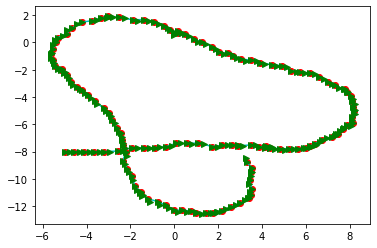

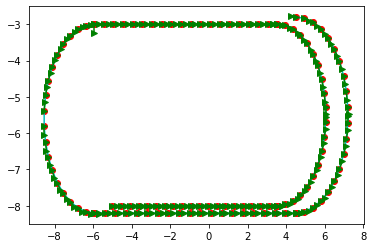

In [22]:
# Plotting trajectory using matplotlib
def draw(X, Y, THETA):
    ax = plt.subplot(111)
    ax.plot(X, Y, 'ro')
    plt.plot(X, Y, 'c-')

    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'g->')

    plt.show()
    return
draw(pose_arr[0],pose_arr[1],pose_arr[2])
draw(gt_arr[0],gt_arr[1],gt_arr[2])
X_gt=gt_arr[0]
Y_gt=gt_arr[1]
Theta_gt=gt_arr[2]
X_init=pose_arr[0]
Y_init=pose_arr[1]
Theta_init=pose_arr[2]
N=X_init.shape[0]
with open('./dataset/edges-poses.g2o', 'w') as filehandle:
    for k in range(N):
        filehandle.writelines("VERTEX_SE2 " )
        a = X_init[k].item(); 
        b = Y_init[k].item(); 
        c = Theta_init[k].item();
        filehandle.writelines(str(k)+" ");
        filehandle.writelines(str(a)+" ");
        filehandle.writelines(str(b)+" ");
        filehandle.writelines(str(c));
        filehandle.writelines("\n");
    filehandle.writelines([l for l in open("./dataset/edges.txt").readlines() if "EDGE_SE2" in l ])

Groundtruth trajectory:


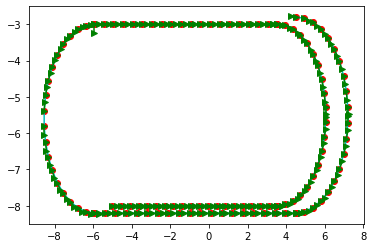

Noisy trajectory:


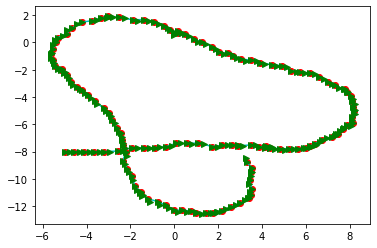

Optimised trajectory at iteration 0


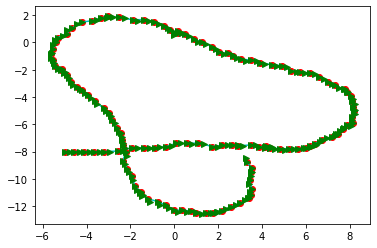

Frobenius norm between manual and jax is: 0.0
Cost at itr 0 is 630151.94
Frobenius norm between manual and jax is: 0.0
Cost at itr 1 is 90798.19
Frobenius norm between manual and jax is: 0.0
Cost at itr 2 is 18706.283
Frobenius norm between manual and jax is: 0.0
Cost at itr 3 is 2378.3809
Frobenius norm between manual and jax is: 0.0
Cost at itr 4 is 2378.3809
Frobenius norm between manual and jax is: 0.0
Cost at itr 5 is 2378.3809
Frobenius norm between manual and jax is: 0.0
Cost at itr 6 is 2378.3809
Frobenius norm between manual and jax is: 0.0
Cost at itr 7 is 2378.3809
Groundtruth trajectory:


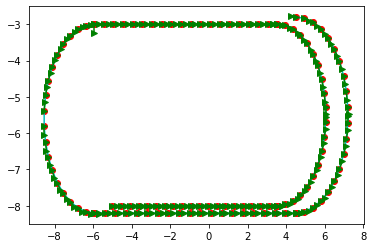

Noisy trajectory:


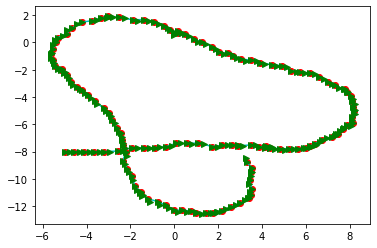

Optimised trajectory at iteration 8


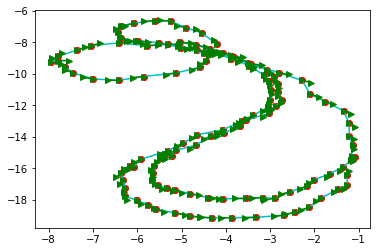

Frobenius norm between manual and jax is: 0.0
Cost at itr 8 is 1142.9055
Frobenius norm between manual and jax is: 0.0
Cost at itr 9 is 1142.9055
Frobenius norm between manual and jax is: 0.0
Cost at itr 10 is 779.55273
Frobenius norm between manual and jax is: 0.0
Cost at itr 11 is 779.55273
Frobenius norm between manual and jax is: 0.0
Cost at itr 12 is 716.82916
Frobenius norm between manual and jax is: 0.0
Cost at itr 13 is 716.82916
Frobenius norm between manual and jax is: 0.0
Cost at itr 14 is 640.2837
Frobenius norm between manual and jax is: 0.0
Cost at itr 15 is 640.2837
Groundtruth trajectory:


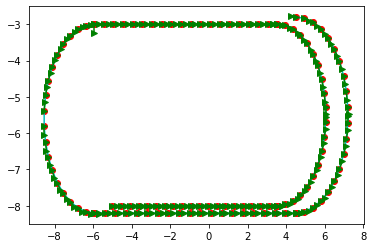

Noisy trajectory:


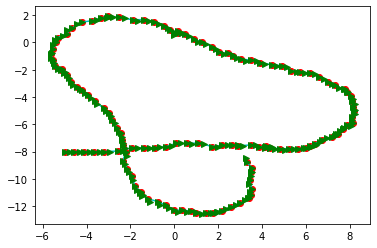

Optimised trajectory at iteration 16


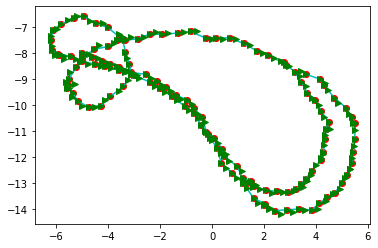

Frobenius norm between manual and jax is: 0.0
Cost at itr 16 is 590.10767
Frobenius norm between manual and jax is: 0.0
Cost at itr 17 is 590.10767
Frobenius norm between manual and jax is: 0.0
Cost at itr 18 is 550.9545
Frobenius norm between manual and jax is: 0.0
Cost at itr 19 is 550.9545
Frobenius norm between manual and jax is: 0.0
Cost at itr 20 is 522.022
Frobenius norm between manual and jax is: 0.0
Cost at itr 21 is 522.022
Frobenius norm between manual and jax is: 0.0
Cost at itr 22 is 500.58438
Frobenius norm between manual and jax is: 0.0
Cost at itr 23 is 500.58438
Groundtruth trajectory:


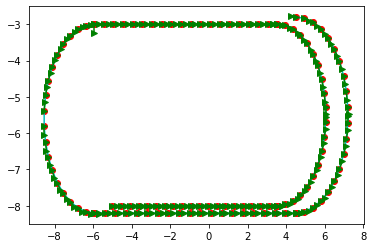

Noisy trajectory:


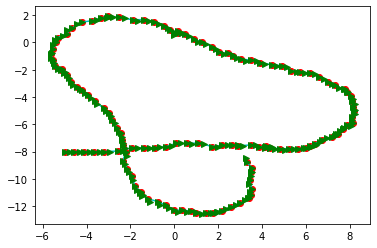

Optimised trajectory at iteration 24


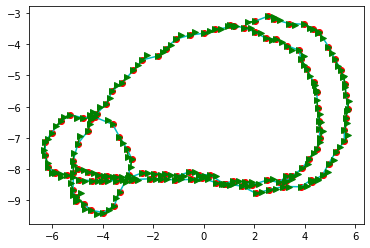

Frobenius norm between manual and jax is: 0.0
Cost at itr 24 is 484.85123
Frobenius norm between manual and jax is: 0.0
Cost at itr 25 is 484.25937
Frobenius norm between manual and jax is: 0.0
Cost at itr 26 is 454.6549
Frobenius norm between manual and jax is: 0.0
Cost at itr 27 is 447.79858
Frobenius norm between manual and jax is: 0.0
Cost at itr 28 is 445.42545
Frobenius norm between manual and jax is: 0.0
Cost at itr 29 is 444.60413
Frobenius norm between manual and jax is: 0.0
Cost at itr 30 is 444.289
Frobenius norm between manual and jax is: 0.0
Cost at itr 31 is 444.16306
Groundtruth trajectory:


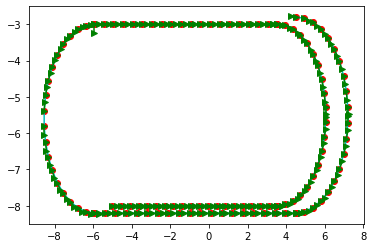

Noisy trajectory:


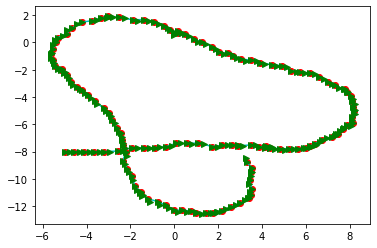

Optimised trajectory at iteration 32


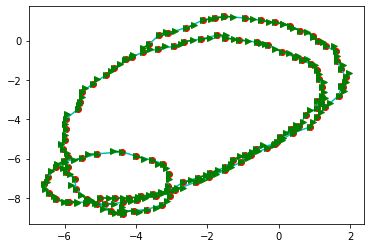

Frobenius norm between manual and jax is: 0.0
Cost at itr 32 is 444.1114
Frobenius norm between manual and jax is: 0.0
Cost at itr 33 is 444.08987
Frobenius norm between manual and jax is: 0.0
Cost at itr 34 is 444.081
Frobenius norm between manual and jax is: 0.0
Cost at itr 35 is 444.07727
Frobenius norm between manual and jax is: 0.0
Cost at itr 36 is 444.07562
Frobenius norm between manual and jax is: 0.0
Cost at itr 37 is 444.075
Frobenius norm between manual and jax is: 0.0
Cost at itr 38 is 444.07465
Frobenius norm between manual and jax is: 0.0
Cost at itr 39 is 444.07462
Groundtruth trajectory:


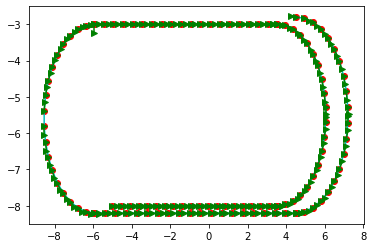

Noisy trajectory:


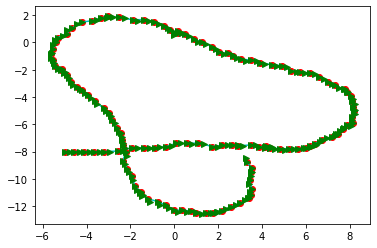

Optimised trajectory at iteration 40


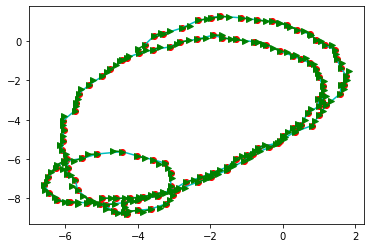

Frobenius norm between manual and jax is: 0.0
Cost at itr 40 is 444.07452
Frobenius norm between manual and jax is: 0.0
Cost at itr 41 is 444.07452
Frobenius norm between manual and jax is: 0.0
Cost at itr 42 is 444.07443
Frobenius norm between manual and jax is: 0.0
Cost at itr 43 is 444.07443
Frobenius norm between manual and jax is: 0.0
Cost at itr 44 is 444.07443
Frobenius norm between manual and jax is: 0.0
Cost at itr 45 is 444.07443
Frobenius norm between manual and jax is: 0.0
Cost at itr 46 is 444.07443
Frobenius norm between manual and jax is: 0.0
Cost at itr 47 is 444.07443
Groundtruth trajectory:


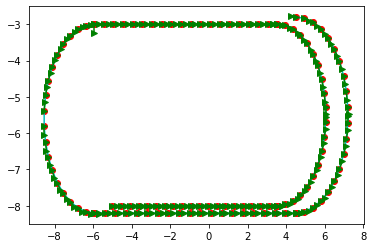

Noisy trajectory:


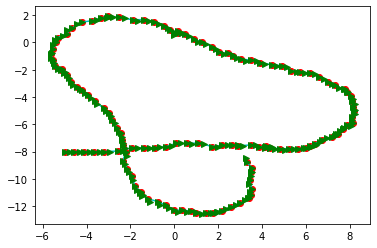

Optimised trajectory at iteration 48


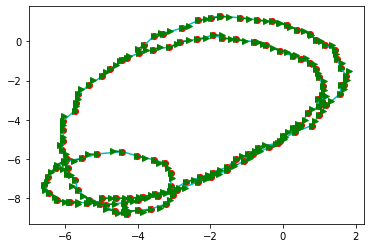

Frobenius norm between manual and jax is: 0.0
Cost at itr 48 is 444.07443
Frobenius norm between manual and jax is: 0.0
Cost at itr 49 is 444.07443
Frobenius norm between manual and jax is: 0.0
Cost at itr 50 is 444.07443
Frobenius norm between manual and jax is: 0.0
Cost at itr 51 is 444.07443
Frobenius norm between manual and jax is: 0.0
Cost at itr 52 is 444.07443
Frobenius norm between manual and jax is: 0.0
Cost at itr 53 is 444.07443
Frobenius norm between manual and jax is: 0.0
Cost at itr 54 is 444.07443
Frobenius norm between manual and jax is: 0.0
Cost at itr 55 is 444.07443
Groundtruth trajectory:


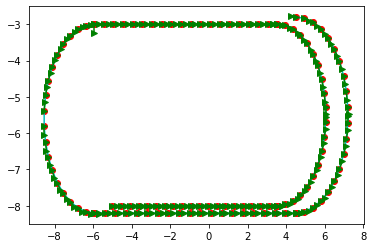

Noisy trajectory:


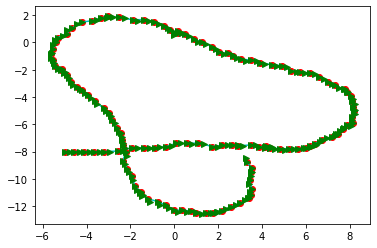

Optimised trajectory at iteration 56


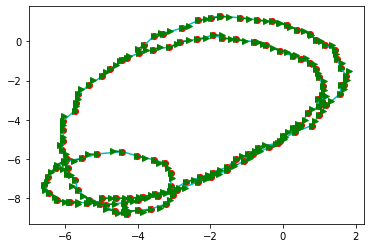

Frobenius norm between manual and jax is: 0.0
Cost at itr 56 is 444.07443
Frobenius norm between manual and jax is: 0.0
Cost at itr 57 is 444.07443
Frobenius norm between manual and jax is: 0.0
Cost at itr 58 is 444.07443
Frobenius norm between manual and jax is: 0.0
Cost at itr 59 is 444.07443
Frobenius norm between manual and jax is: 0.0
Cost at itr 60 is 444.07443
Frobenius norm between manual and jax is: 0.0
Cost at itr 61 is 444.07443
Frobenius norm between manual and jax is: 0.0
Cost at itr 62 is 444.07443
Frobenius norm between manual and jax is: 0.0
Cost at itr 63 is 444.07443
Groundtruth trajectory:


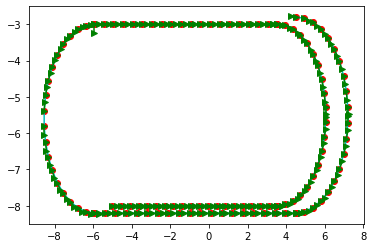

Noisy trajectory:


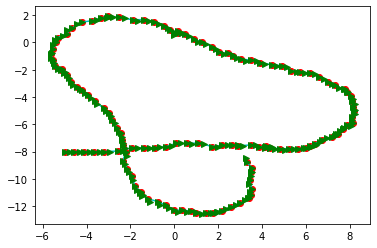

Optimised trajectory at iteration 64


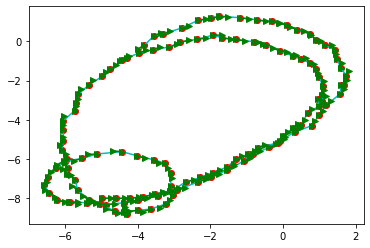

Frobenius norm between manual and jax is: 0.0
Cost at itr 64 is 444.07443
64


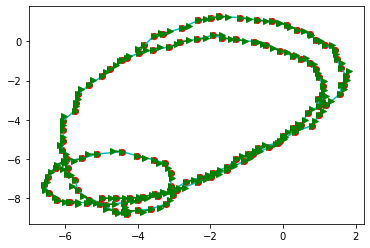

In [23]:
### jax.ops.index_update(res,jax.ops.index[i-1,0],x[i-1][0]+u[i-1][0]-x[i][0])
def compute_residual_robotpath(X,Y,Theta,ind1,ind2,del_x,del_y,del_theta):
    r=jnp.empty((0,1))
    for i in range(0,len(ind1)):
        a=ind1[i]
        b=ind2[i]
        val_x=X[a]+del_x[i]*jnp.cos(Theta[a])-del_y[i]*jnp.sin(Theta[a])-X[b]
        val_y=Y[a]+del_y[i]*jnp.cos(Theta[a])+del_x[i]*jnp.sin(Theta[a])-Y[b]
        val_th=Theta[a]+del_theta[i]-Theta[b]
        arr=jnp.array([[val_x],
                      [val_y],
                      [val_th]])
        r=jnp.append(r,arr,axis=0)
    val_x=X[0]+5
    val_y=Y[0]+8
    val_th=Theta[0]-0
    arr=jnp.array([[val_x],
                  [val_y],
                  [val_th]])
    r=jnp.append(r,arr,axis=0)
    
    return r
#residual=compute_residual_robotpath(X_init,Y_init,Theta_init,ind1,ind2,del_x,del_y,del_theta)
#print(residual)
def compute_jacobian_robotpath(X,Y,Theta,ind1,ind2,del_x,del_y,del_theta):
    J=jnp.empty((0,360))
    for i in range(0,len(ind1)):
        arr=jnp.zeros((1,360))
        a=ind1[i]
        b=ind2[i]
        arr=jax.ops.index_update(arr,jax.ops.index[0,a],1)
        arr=jax.ops.index_update(arr,jax.ops.index[0,b],-1)
        arr=jax.ops.index_update(arr,jax.ops.index[0,240+a],(-del_x[i]*jnp.sin(Theta[a])-del_y[i]*jnp.cos(Theta[a])))
        J=jnp.append(J,arr,axis=0)
        arr=jnp.zeros((1,360))
        arr=jax.ops.index_update(arr,jax.ops.index[0,120+a],1)
        arr=jax.ops.index_update(arr,jax.ops.index[0,120+b],-1)
        arr=jax.ops.index_update(arr,jax.ops.index[0,240+a],(-del_y[i]*jnp.sin(Theta[a])+del_x[i]*jnp.cos(Theta[a])))
        J=jnp.append(J,arr,axis=0)
        arr=jnp.zeros((1,360))
        arr=jax.ops.index_update(arr,jax.ops.index[0,240+a],1)
        arr=jax.ops.index_update(arr,jax.ops.index[0,240+b],-1)
        J=jnp.append(J,arr,axis=0)
    arr=jnp.zeros((1,360))
    arr=jax.ops.index_update(arr,jax.ops.index[0,0],1)
    J=jnp.append(J,arr,axis=0)
    arr=jnp.zeros((1,360))
    arr=jax.ops.index_update(arr,jax.ops.index[0,120],1)
    J=jnp.append(J,arr,axis=0)
    arr=jnp.zeros((1,360))
    arr=jax.ops.index_update(arr,jax.ops.index[0,240],1)
    J=jnp.append(J,arr,axis=0)
    
    return J
#Jacob=compute_jacobian_robotpath(X_init,Y_init,Theta_init,ind1,ind2,del_x,del_y,del_theta)
#print(jnp.shape(Jacob))
def compute_residual_forjax(x,ind1,ind2,del_x,del_y,del_theta):
    r=jnp.empty((0,1))
    #r=jnp.zeros((420,1))
    for i in range(0,len(ind1)):
        a=ind1[i]
        b=ind2[i]
        val_x=x[a]+del_x[i]*jnp.cos(x[a+240])-del_y[i]*jnp.sin(x[a+240])-x[b]
        val_y=x[a+120]+del_y[i]*jnp.cos(x[a+240])+del_x[i]*jnp.sin(x[a+240])-x[b+120]
        val_th=x[a+240]+del_theta[i]-x[b+240]
        arr=jnp.array([[val_x],
                      [val_y],
                      [val_th]])
        r=jnp.append(r,arr,axis=0)
       # r=jax.ops.index_update(r,jax.ops.index[3*i,0],val_x)
        #r=jax.ops.index_update(r,jax.ops.index[3*i+1,0],val_y)
        #r=jax.ops.index_update(r,jax.ops.index[3*i+2,0],val_th)
    val_x=x[0]+5
    val_y=x[120]+8
    val_th=x[240]-0
    arr=jnp.array([[val_x],
                  [val_y],
                  [val_th]])
    r=jnp.append(r,arr,axis=0)
    #r=jax.ops.index_update(r,jax.ops.index[417,0],val_x)
    #r=jax.ops.index_update(r,jax.ops.index[418,0],val_y)
    #r=jax.ops.index_update(r,jax.ops.index[419,0],val_th)
    
    
    return r

def frobNorm(P1, P2, str1="mat1", str2="mat2"):
    jnp.set_printoptions(suppress=True)
    val = jnp.linalg.norm(P1 - P2, 'fro')
    print(f"Frobenius norm between {str1} and {str2} is: {val}")
    return


def compute_Jacobian_frm_jax(x_in,ind1,ind2,del_x,del_y,del_theta):
    f = lambda x: compute_residual_forjax(x, ind1, ind2,del_x,del_y,del_theta)
    J = jacfwd(f)
    #x_in=jnp.array([x_in])
    #print(jnp.shape(x_in))
    #print(J(x_in))
    return J(x_in)

def compute_info_mat(ind1,ind2,od_val,lc_val,fix_val) :
    info_mat=jnp.identity(3*len(ind1)+3)
    for i in range(0,360):
        info_mat=jax.ops.index_update(info_mat,jax.ops.index[i,i],od_val)
    for i in range(360,3*len(ind1)):
        info_mat=jax.ops.index_update(info_mat,jax.ops.index[i,i],lc_val)
    info_mat=jax.ops.index_update(info_mat,jax.ops.index[3*len(ind1),3*len(ind1)],fix_val)
    info_mat=jax.ops.index_update(info_mat,jax.ops.index[3*len(ind1)+1,3*len(ind1)+1],fix_val)
    info_mat=jax.ops.index_update(info_mat,jax.ops.index[3*len(ind1)+2,3*len(ind1)+2],fix_val)
    return info_mat
omega=compute_info_mat(ind1,ind2,500,700,1000)

def LM_algo(X_init,Y_init,Theta_init,maxiter,threshold,lam,del_x,del_y,del_theta,ind1,ind2,omega):
    itr=0
    X=X_init
    Y=Y_init
    Theta=Theta_init
   # print(jnp.shape([X]), jnp.shape([Y]), jnp.shape([Theta]))
    x=jnp.empty((0,1))
    x=jnp.append(x,jnp.array([X]).T,axis=0)
    x=jnp.append(x,jnp.array([Y]).T,axis=0)
    x=jnp.append(x,jnp.array([Theta]).T,axis=0)
    #print(jnp.shape(x))
    while(itr<maxiter):
        if itr%8==0:
            print("Groundtruth trajectory:")
            draw(X_gt,Y_gt,Theta_gt)
            print("Noisy trajectory:")
            draw(X_init,Y_init,Theta_init)
            #draw(X_gt,Y_gt,Theta_gt)
            print("Optimised trajectory at iteration "+str(itr))
            draw(X,Y,Theta)
        J=compute_jacobian_robotpath(X,Y,Theta,ind1,ind2,del_x,del_y,del_theta)
        x_list=x.T[0]
        #print(x_list)
        J1=compute_Jacobian_frm_jax(x_list,ind1,ind2,del_x,del_y,del_theta)
        #print(jnp.shape(J), jnp.shape(J1))
        #print(J1)
        J1=J1[:,0,:]
        frobNorm(J,J1,"manual","jax")
        r=compute_residual_robotpath(X,Y,Theta,ind1,ind2,del_x,del_y,del_theta)
        A=(J.T@omega)@J
        A=A+lam*jnp.identity(len(A))
        B=(J.T@omega.T)@r
        step=jnp.linalg.inv(A)@B
        x1=x-step
        x2=x
        X1=x1[0:120,:]
        Y1=x1[120:240,:]
        Theta1=x1[240:360,:]
        #print(jnp.shape(X1), jnp.shape(Y1),jnp.shape(Theta1))
        c=(0.5*(r.T@omega)@r)[0][0]
        print("Cost at itr "+str(itr)+" is "+str(c))
        r1=compute_residual_robotpath(X1.T[0],Y1.T[0],Theta1.T[0],ind1,ind2,del_x,del_y,del_theta)
        c1=(0.5*(r1.T@omega)@r1)[0][0]
        if c1<=c:
            lam=lam/10
            x=x1
            X=(x1[0:120,:]).T[0]
            Y=(x1[120:240,:]).T[0]
            Theta=(x1[240:360,:]).T[0]
        else:
            lam=lam*10
            x=x2
            X=(x2[0:120,:]).T[0]
            Y=(x2[120:240,:]).T[0]
            Theta=(x2[240:360,:]).T[0]
        #if c1<=c:  
        flag=check_conv(x1,x2,threshold)
        if flag:
            print(itr)
            return(X1.T[0],Y1.T[0],Theta1.T[0])
        #x=x1
        #X=(x[0:120,:]).T[0]
        #Y=(x[120:240,:]).T[0]
        #Theta=(x[240:360,:]).T[0]
        itr=itr+1
    return(X,Y,Theta)
(X_opt,Y_opt,Theta_opt)=LM_algo(X_init,Y_init,Theta_init,200,1e-4,0.01,del_x,del_y,del_theta,ind1,ind2,omega)

draw(X_opt,Y_opt,Theta_opt)
def find_newedges(X_opt,Y_opt,Theta_opt,del_x,del_y,del_theta):
    del_xn=del_x
    del_yn=del_y
    del_thetan=del_theta
    for i in range(0,len(X_opt-1)):
        dx_w=X_opt[i+1]-X_opt[i]
        dy_w=Y_opt[i+1]-Y_opt[i]
        dth=Theta_opt[i+1]-Theta_opt[i]
        dx_r=dx_w*jnp.cos(Theta_opt[i])+dy_w*jnp.sin(Theta_opt[i])
        dy_r=dx_w*(-jnp.sin(Theta_opt[i]))+dy_w*jnp.cos(Theta_opt[i])
        del_xn=jax.ops.index_update(del_xn,jax.ops.index[i],dx_r)
        del_yn=jax.ops.index_update(del_yn,jax.ops.index[i],dy_r)
        del_thetan=jax.ops.index_update(del_thetan,jax.ops.index[i],dth)
    return (del_xn,del_yn,del_thetan)
(del_xn,del_yn,del_thetan)=find_newedges(X_opt,Y_opt,Theta_opt,del_x,del_y,del_theta)


N=X_opt.shape[0]
def write_optg2ofile(edval,N,N_e,del_xn,del_yn,del_thetan):
    with open('./dataset/opt.g2o', 'w') as filehandle:
        for k in range(N):
            filehandle.writelines("VERTEX_SE2 " )
            a = X_opt[k].item(); 
            b = Y_opt[k].item(); 
            c = Theta_opt[k].item();
            filehandle.writelines(str(k)+" ");
            filehandle.writelines(str(a)+" ");
            filehandle.writelines(str(b)+" ");
            filehandle.writelines(str(c));
            filehandle.writelines("\n");
        for k in range(N_e):
            filehandle.writelines("EDGE_SE2 ")
            a=del_x[k].item();
            b=del_y[k].item();
            c=del_theta[k].item();
            filehandle.writelines(str(k)+" ");
            filehandle.writelines(str(k+1)+" ")
            filehandle.writelines(str(a)+" ");
            filehandle.writelines(str(b)+" ");
            filehandle.writelines(str(c)+" ");
            filehandle.writelines(str(edval)+" 0.0 0.0 "+str(edval)+" 0.0 "+str(edval))
            filehandle.writelines("\n");
        filehandle.writelines("FIX 0")
        filehandle.writelines("\n");
    return
write_optg2ofile(500,N,119,del_xn,del_yn,del_thetan)
    
        
        
        
    
    

In [24]:
os.system("python misc/g2o_to_kitti.py dataset/gt.g2o dataset/gt.kitti")
os.system("python misc/g2o_to_kitti.py dataset/opt.g2o dataset/opt.kitti")
os.system("evo_rpe kitti dataset/gt.kitti dataset/opt.kitti -v --plot --plot_mode xy")
os.system("evo_ape kitti dataset/gt.kitti dataset/opt.kitti -v --plot --plot_mode xy")
os.system("evo_traj kitti dataset/gt.kitti dataset/opt.kitti -v --plot --plot_mode xy")

0

## 2.1 Answer

Give a detailed answer addressing the above questions. When I run the above code, it should follow points described above (such as plots at every 10 steps) and (When I run the above code, it should) write the optimized poses to a file named `opt.g2o`. As a backup, save another file `opt_backup.g2o` in an offline manner beforehand.

That apart, save important plots and add them here so that it can supplement your answer, for example you could add plots at crucial stages of optimization. You have to add useful metrics/plots from `EVO` (refer to supplementary notebook). Using EVO, the bare minimum you have to report is `mean absolute pose error (ape)` and `mean relative pose error (rpe)`. However, you are encouraged to use tools like `evo_traj` and [more](https://github.com/MichaelGrupp/evo/#command-line-interface) and add more plots/metrics. Marks will be awarded based on overall analysis & presentation which would reflect your understanding.

Note that `EVO` and `g2o_viewer` (below) could help you in debugging.

Add answer for 2.1 here:\
Dimensions of Jacobian-> (420x360)\
Dimensions of Residual-> (420x1)\
Brief explanation: Number of columns in Jacobian are 360 because the variables with respect to which the equation must be differentiated are X[i],Y[i],Theta[i] where i is the ith pose. There are 120 poses in total(0-119) So total variables=360. Thus number of columns in J matrix is 360.\
To find number of rows in J, it is enough to find the number of rows in the residual as that many number of equations need to be differentiated.\
For finding this, \
Each edge gives 3 equations f(xi)-xj,f(yi)-yj,f(zi)-zj\
There are 119 edges(normal) and 20 loop closure edges->139 edges->417 equations\
Finally we are anchoring vertex 0\
This gives another 3 equations(wrt x,y,theta)\
Therefore dimension of residual=420x1 and number of rows in Jacobian=420

#### Ground truth trajectory

<img src="misc/groundtruth.png">

#### Initial Noisy trajectory

<img src="misc/noisyinit.png">

#### Final Optimised trajectory

<img src="misc/finalopt.png">


|Info values(odometry, Loop closure, anchor)|Final error|No. of iterations|RPE|APE|Trajectory|XYZ|RPE|
:-------------------------:|:-------------------------:|:----------------:|:---:|:---:|:---:|:---:|:---|
500,700,1000   | 444.07443|64 |![rp1](misc/2_1_500_700_100_rpe.png) | ![ap1](misc/2_1_500_700_100_mpe.png) | ![t1](misc/2_1_500_700_100_evo.png)|![xyz1](misc/2_1_500_700_1000_xyz.png)|![rpy1](misc/2_1_500_700_1000_rpy.png) 
250,500,1000   |226.6265 |79| ![rp2](misc/2_1_250_500_1000_rpe.png) | ![ap2](misc/2_1_250_500_1000_mpe.png) | ![t2](misc/2_1_250_500_1000_evo.png)|![xyz1](misc/2_1_250_500_1000_xyz.png)|![rpy1](misc/2_1_250_500_1000_rpy.png)
100,500,1000   | 93.598 |59| ![rp2](misc/2_1_100_500_1000_rpe.png) | ![ap2](misc/2_1_100_500_1000_ape.png) | ![t2](misc/2_1_100_500_1000_evo.png)|![xyz1](misc/2_1_100_500_1000_xyz.png)|![rpy1](misc/2_1_100_500_1000_rpy.png) 
100,500,750   |93.59799 |63| ![rp2](misc/2_1_100_500_750_rpe.png) | ![ap2](misc/2_1_100_500_750_ape.png) | ![t2](misc/2_1_100_500_750_evo.png)|![xyz1](misc/2_1_100_500_750_xyz.png)|![rpy1](misc/2_1_100_500_750_rpy.png)
50,250,700   |46.798992|63| ![rp2](misc/2_1_50_250_700_rpe.png) | ![ap2](misc/2_1_50_250_700_ape.png) | ![t2](misc/2_1_50_250_700_evo.png)|![xyz1](misc/2_1_50_250_700_xyz.png)|![rpy1](misc/2_1_50_250_700_rpy.png)
5,700,1000   |4.820871|187| ![rp2](misc/2_1_5_700_1000_rpe.png) | ![ap2](misc/2_1_5_700_1000_ape.png) | ![t2](misc/2_1_5_700_1000_evo.png)|![xyz1](misc/2_1_5_700_1000_xyz.png)|![rpy1](misc/2_1_5_700_1000_rpy.png)
10,500,700   |9.629605|>100| ![rp2](misc/2_1_10_500_700_rpe.png) | ![ap2](misc/2_1_10_500_700_ape.png) | ![t2](misc/2_1_10_500_700_evo1.png)|![xyz1](misc/2_1_10_500_700_xyz.png)|![rpy1](misc/2_1_10_500_700_rpy.png)

From the table and plots above we can see that :\
-> If the value of odometry is very less compared to closure and anchor points like in (5,700,1000) and (10,700,1000) , we can that final trajectory generated is bad even though the error is small.\
 This is because the optimiser assumes that odometry can be neglected and optimised w.r.t loop closure and anchor ponts.\
->But, we can keep the info values for Anchor points high as these points are not from odometry or loop closure and need to be optimised perfectly\
-> If the info values of odometry and loop closure are too far (e.g 5,700,1000), we see that the it doesnt coverge within 100 iterations and the trajectory is not proper.\
-> Whereas, if the values of odometry and loop closure are very close(e.g 500,700,1000) , even though it converges and the trajectory is good, the error value is quiet high.

### 1) 500,700,1000

#### RPE

       max	0.286780
      mean	0.116583
    median	0.108951
       min	0.006496
      rmse	0.132555
       sse	2.090924
       std	0.063081

#### APE

       max	10.025226
      mean	5.212679
    median	5.591737
       min	0.000001
      rmse	6.060879
       sse	4408.111216
       std	3.092286
       
#### Traj
name:	gt \
infos: \
	nr. of poses	120 \
	path length (m)	52.976517997999295 \
	pos_end (m)	[-2.8 -4.5  0. ] \
	pos_start (m)	[-8.  5.  0.]  

name:	opt \
infos: \
	nr. of poses	120 \ 
	path length (m)	53.77115766834177 \ 
	pos_end (m)	[-0.19617024  3.81814361  0.        ] \
	pos_start (m)	[-8.00000095  4.99999905  0.        ] 
    
### 2) 10,500,700

#### RPE 

       max	0.286823
      mean	0.117092
    median	0.113842
       min	0.006281
      rmse	0.131988
       sse	2.073078
       std	0.060913

#### APE 

       max	9.992695
      mean	5.209285
    median	5.572095
       min	0.000000
      rmse	6.056114
       sse	4401.182151
       std	3.088667
#### Traj
name:	gt \
infos:\
	nr. of poses	120\
	path length (m)	52.976517997999295\
	pos_end (m)	[-2.8 -4.5  0. ]\
	pos_start (m)	[-8.  5.  0.]

name:	opt\
infos:\
	nr. of poses	120\
	path length (m)	53.75901490585002\
	pos_end (m)	[-0.17110129  3.8036623   0.        ]\
	pos_start (m)	[-8.  5.  0.]

### 3) 100,500,1000

#### RPE 

       max	0.286802
      mean	0.116699
    median	0.114653
       min	0.006368
      rmse	0.131941
       sse	2.071614
       std	0.061563


#### APE 

    max	9.999472
      mean	5.208980
    median	5.578270
       min	0.000000
      rmse	6.055855
       sse	4400.805973
       std	3.088674
#### Traj

name:	gt\
infos:\
	nr. of poses	120\
	path length (m)	52.976517997999295\
	pos_end (m)	[-2.8 -4.5  0. ]\
	pos_start (m)	[-8.  5.  0.]

name:	opt\
infos:\
	nr. of poses	120\
	path length (m)	53.75806968761724\
	pos_end (m)	[-0.17907065  3.80502105  0.        ]\
	pos_start (m)	[-8.          4.99999952  0.        ]
    
 ### 4) 50,250,700
 
 #### RPE 

       max	0.286802
      mean	0.116698
    median	0.114653
       min	0.006368
      rmse	0.131941
       sse	2.071599
       std	0.061563

#### APE 

       max	9.998228
      mean	5.208433
    median	5.577930
       min	0.000000
      rmse	6.055183
       sse	4399.828428
       std	3.088279
#### Traj
name:	gt\
infos:\
	nr. of poses	120\
	path length (m)	52.976517997999295\
	pos_end (m)	[-2.8 -4.5  0. ]\
	pos_start (m)	[-8.  5.  0.]\
name:	opt\
infos:\
	nr. of poses	120\
	path length (m)	53.75808050140032\
	pos_end (m)	[-0.17900524  3.80388379  0.        ]\
	pos_start (m)	[-8.          4.99999952  0.        ]
  

## 2.2 Using g2o's optimization: g2o binary or g2o viewer 

Installation setup is described in supplementary notebook. More details for 2.2.1 and 2.2.2 can be found in the supplementary notebook.

### 2.2.1 Optimizing `edges.txt`
First task is to optimize the poses of dataset you've been working with so far.

### 2.2.2 Optimizing `intel` and `sphere` datasets
You have been given two datasets in the `data` folder. You have to use `g2o_viewer` to optimize these both. You have to experiment with the options/parameters available in the GUI. More instructions in supplementary notebook. You have to experiment till you get the trajectories which look like the following:

<table><tr>
<td> <img src="./misc/intel.jpg" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="./misc/sphere.jpg" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>

## 2.2 Answer

### Optimising edges-poses.g2o:
Here directly running the default optimizing technique of g2o(gn_var_cholmod) for 10 iterations is sufficient to get the optimised trajectory close to Ground truth.(This is because maybe the data size is small)
 #### Initial edges.txt Trajectory
<img src="misc/edges_g2o_un.png">

 #### Final edges.txt Trajectory

<img src="misc/edges_g2o_opt.png">

### Optimising intel.g2o:
Here also we tried to optimize the trajectory using default optimization technique(gn_var_cholmod) for 2 different values of max iterations(10,100). In both cases, the optimised trajectory looked veryclose to ground truth(Maybe this is also due to less data size)

#### Initial intel.g2o

<img src="misc/intel_g2o_un.png">

#### Optimised intel.g2o (10 itr)

<img src="misc/intel_g2o_opt_10.png">

#### Optimised intel.g2o (100 itr)

<img src="misc/intel_g2o_opt_100.jpeg">

### Optimising sphere.g2o:
Here first we tried to optimise with the default optimizer(for different number of iterations-(100,200)), but it couldn't converge to the ground truth(The bottom part of the sphere had a bun like structure going inside).
So we needed to change the optimizer. We started to look from top to bottom and finally found that this could be optimized to ground truth for the optimizer(lm_fix6_3_cholmod) for max iterations=200

I think this is may be due to the fact that LM is more robust than Gauss-Newton(Insights from assignment-3) so maybe this worked for large datasets.

#### Initial sphere.g2o

<img src="misc/sphere_g2o_ini.png">

#### sphere_g2o optimised using default gn_var_cholmod (itr=100)

<img src="misc/sphere_g2o_un.jpeg">

#### Final sphere.g2o 

<img src="misc/sphere_g2o_opt.jpeg">

###  * Important Information regarding Questions 3  & 4
Note that it is mandatory to attempt EITHER 3 OR 4, only one of it. If you attempt both, the question which you score more will be considered and the other as bonus question. 

It is encouraged for those into robotics/deep learning research to prefer 4 over 3.

# [Bonus*] 3. Deriving Motion model geometrically
\* -> read information above under section "Important Information regarding Questions 3  & 4"

 
The current robot state is as follows: ($i$ and $k$ are interchangably used below, sorry I am too lazy to edit now ðŸ˜›)  
![robot-situation.png](./misc/robot-situation.png)

Can you derive the below equation using geometry? (Read on)

$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

In other words, we want to find $\delta$'s in terms of $\Delta$'s
$$\delta x = \Delta x \cos(\theta) - \Delta y \sin(\theta) \\
\delta y = \Delta y \cos(\theta) + \Delta x \sin(\theta) \tag{2}$$

where $\delta$'s are the updates in our motion model equation:
$$ x_{k+1} = x_{k} + \delta x \\
y_{k + 1} = y_k + \delta y \\
\theta_{k+1} = \theta_{k} + \delta \theta \tag{1}$$

Oh yes, $\theta$ is straightforward, i.e. $\delta \theta = \Delta \theta$ but why? 

Using geometry, you could just draw and insert a self-explanatory image as the answer to this question.

If you can derive it without using geometry purely using transform matrices/algebra, that is fine too. Whatever you're comfortable.

## 3. Answer
<img src="misc/3_1.jpeg"  width="42000" height="42000" >
<img src="misc/3_2.jpeg"  width="42000" height="42000" >

### 3
Note that $\delta\theta = \Delta\theta $ because rotation in any xy plane really doesnt matter as $\Delta\theta$ is measured along z-axis.\
In simple terms,\
If we rotate a robot with respect to frame at $ (x_k,y_k) $ by $\Delta\theta $, it is equivalent to rotation of $\Delta\theta$ in world frame i.e amount of rotation is same w.r.t both frames.\
Hence \
$$\theta_{k+1}=\theta_k +\Delta\theta $$

# [Bonus*] 4. Research Paper Reading
\* -> read information above under section "Important Information regarding Questions 3  & 4"

(Do not get intimidated, you are not expected to do a thorough research analysis for this task. A high level understanding is sufficient.)


["Past, Present & Future of SLAM: Towards the Robust Perception Age"](https://arxiv.org/abs/1606.05830) is an exciting survey paper of 2016 which sums up, well, the "past, present & future" of SLAM. Your task is as follows:

1. Go through the sections "IV. LONG-TERM AUTONOMY II: SCALABILITY" & "III. LONG-TERM AUTONOMY I: ROBUSTNESS". Don't worry, you are not expected to have a deep understanding. Skip the parts which you don't understand at all. Go through it at a high level, and take a slightly closer look at "Open Problems" in these sections.

2. Read up common applications of deep learning for computer vision/robotics through blogs online (for example, first 4 points of [this](https://machinelearningmastery.com/applications-of-deep-learning-for-computer-vision/). Again, you are only expected to understand it at a high level, for example, 'semantic segmentation is an application of deep learning for computer vision which is the task of assigning a category to each of the pixels in the image'.

Firstly, summarize your understanding of the above two points.
   
Now, from the understanding you've gathered so far, how would you approach solving those "Open Problems"? 
Can these algorithms help in dealing with some of the issues you might have faced during this project? Can the deep learing based high level understanding of the world help in SLAM? In the context of long term autonomy, imagine tomorrow's world with a buddy robot R2-D2 which follows you wherever you go... Now imagine how easily the trajectory can diverge, how big the map could soon become and how the computation could easily become intractable.   

Answer the above questions in the context of this project and those 2 sections of the survey paper.

## 4. Answer


Your answer here.

### Fun section
Check the end of your Project-1 homepage on Notion. :)